<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/22_NLP_Course_Week_3_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [32]:
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 160000
test_portion = .1

corpus = []

In [33]:
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
-O /tmp/training_cleaned.csv

--2021-01-08 11:19:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   183MB/s    in 1.2s    

2021-01-08 11:19:28 (183 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [35]:
import pandas as pd

data = pd.read_csv('/tmp/training_cleaned.csv', header = None)
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [36]:
data.tail(1)

,0,1,2,3,4,5
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [37]:
data[0].unique()

array([0, 4])

In [38]:
num_sentences = 0

for i in range(len(data[0])) :

  list_item = []
  num_sentences = num_sentences + 1

  list_item.append(data[data.columns[5]][i])
  if data[data.columns[0]][i] == 4 :
    list_item.append(1)
  elif data[data.columns[0]][i] == 0 :
    list_item.append(0)

  corpus.append(list_item)

In [39]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [43]:
sentences = []
labels = []

random.shuffle(corpus)

for x in range(training_size) :
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding = padding_type, truncating = trunc_type, maxlen = max_length)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

In [44]:
print(vocab_size)
print(word_index['i'])

138342
1


In [45]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2021-01-08 11:27:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   183MB/s    in 1.8s    

2021-01-08 11:27:51 (183 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [46]:
print(len(embeddings_matrix))

138343


In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = max_length, weights = [embeddings_matrix], trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13834300  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 13,919,561
Trainable params: 85,261
Non-trainable params: 13,834,300
_________________________________________________________________


In [49]:
num_epochs = 50

history = model.fit(
    training_sequences,
    np.array(training_labels),
    epochs = num_epochs,
    validation_data = (test_sequences, np.array(test_labels))
)

print('Training Complete')

Epoch 1/50
4500/4500 [==============================] - 61s 13ms/step - loss: 0.5659 - acc: 0.6980 - val_loss: 0.5268 - val_acc: 0.7266
Epoch 2/50
4500/4500 [==============================] - 57s 13ms/step - loss: 0.4887 - acc: 0.7622 - val_loss: 0.4881 - val_acc: 0.7619
Epoch 3/50
4500/4500 [==============================] - 58s 13ms/step - loss: 0.4636 - acc: 0.7778 - val_loss: 0.4818 - val_acc: 0.7663
Epoch 4/50
4500/4500 [==============================] - 58s 13ms/step - loss: 0.4362 - acc: 0.7949 - val_loss: 0.4798 - val_acc: 0.7701
Epoch 5/50
4500/4500 [==============================] - 58s 13ms/step - loss: 0.4166 - acc: 0.8049 - val_loss: 0.4830 - val_acc: 0.7721
Epoch 6/50
4500/4500 [==============================] - 59s 13ms/step - loss: 0.3948 - acc: 0.8188 - val_loss: 0.4936 - val_acc: 0.7662
Epoch 7/50
4500/4500 [==============================] - 58s 13ms/step - loss: 0.3753 - acc: 0.8293 - val_loss: 0.4998 - val_acc: 0.7655
Epoch 8/50
4500/4500 [==========================

<Figure size 432x288 with 0 Axes>

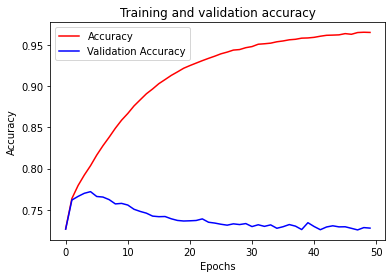

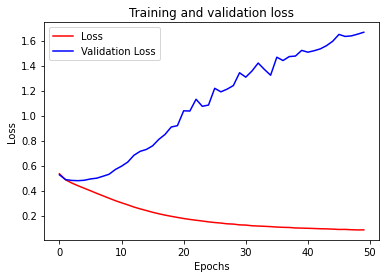

<Figure size 432x288 with 0 Axes>

In [51]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!